In [1]:
import operator
import pathlib
import re

import pandas as pd

FORMAT = {'na_values': '', 'keep_default_na': False}

CH = {'country_code': 'CH',
      'url': 'https://de.wikipedia.org/wiki/Liste_der_gr%C3%B6ssten_Glocken_der_Schweiz',
      'format': {'index_col': 'Name', **FORMAT},
      'note_col': 'Schlagton (HT-1/16)'}

DE = {'country_code': 'DE',
      'url': 'https://de.wikipedia.org/wiki/Liste_von_Glocken_in_Deutschland',
      'format': {'index_col': 'Name',  **FORMAT},
      'note_col': 'Ton:'}

FR = {'country_code': 'FR',
      'url': 'https://fr.wikipedia.org/wiki/Liste_des_bourdons_de_France',
      'format': {'index_col': 'Nom',  **FORMAT},
      'note_col': 'Note(éventuelle justesseen 16e de ton)'}

BELLS = {bells['country_code']: bells for bells in (CH, DE, FR)}

NOTES = [note
         for c_note in 'CDEFGAB'
         for sign in ('',  '#')
         for note in [f'{c_note}{sign}']
         if note not in ('E#', 'B#')]

assert len(NOTES) == 12

MIDI_NOTES = [midi_note
              for octave in range(-1, 10)
              for note in NOTES
              for midi_note in [f'{note}{octave:d}']
              if midi_note not in ('G#9', 'A9', 'A#9', 'B9')]

assert len(MIDI_NOTES) == 128
assert MIDI_NOTES[60] == 'C4'
assert MIDI_NOTES[69] == 'A4'


pd.Series(MIDI_NOTES, dtype='string').to_frame('midi_note')

,midi_note
0,C-1
1,C#-1
2,D-1
3,D#-1
4,E-1
...,...
123,D#9
124,E9
125,F9
126,F#9


In [2]:
def iterenharmonic(raw_c_notes='abcdefg'):
    """Yield pairs of raw note name and corresponding canonical representation."""
    for raw_note in raw_c_notes:
        yield raw_note, raw_note.upper()

    yield 'h', 'B'

    for raw_note in raw_c_notes:
        sharp = 'C' if raw_note == 'b' else 'F' if raw_note == 'e' else f'{raw_note[0].upper()}#'
        yield f'{raw_note}_sharp', sharp

    for raw_note, enh_note in zip(raw_c_notes, raw_c_notes[-1:] + raw_c_notes[:-1]):
        flat = 'B' if raw_note == 'c' else 'E' if raw_note == 'f' else f'{enh_note.upper()}#'
        yield f'{raw_note}_flat', flat


CANONICAL = dict(iterenharmonic())

assert set(CANONICAL.values()) == set(NOTES)

pd.Series(CANONICAL, dtype='string').to_frame('note')

,note
a,A
b,B
c,C
d,D
e,E
f,F
g,G
h,B
a_sharp,A#
b_sharp,C


In [3]:
def read_bells_html(country_code, url, format, *, note_col, encoding='utf-8'):
    del note_col
    path = pathlib.Path(f'bells_{country_code.lower()}.csv')
    if not path.exists():
        df = pd.concat(pd.read_html(url, **format))
        df.convert_dtypes().to_csv(path, encoding=encoding)
    return pd.read_csv(path, encoding=encoding, **format).convert_dtypes()


ch = read_bells_html(**BELLS['CH'])
de = read_bells_html(**BELLS['DE'])
fr = read_bells_html(**BELLS['FR'])

ch.info()
de.info()
fr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, Grosse Glocke to nan
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Ort, Kirche                    78 non-null     string
 1   Schlagton (HT-1/16)            78 non-null     string
 2   Masse(kg, ca.)                 78 non-null     string
 3   Giesser, Gussort               78 non-null     string
 4   Gussjahr                       78 non-null     string
 5   Disposition des Gesamtgeläuts  78 non-null     string
dtypes: string(6)
memory usage: 4.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, Petersglocke(im Volksmund Decke Pitter, Dicker Pitter) to Katharinaglocke
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Nr.              452 non-null    Int64 
 1   Bild             1 non-null      string
 2   Gebäude          452 non-nul

In [4]:
fr['Poidsen kg'].fillna(fr['Masse (en kg)'], inplace=True)
fr[FR['note_col']].fillna(fr["Note (diapason de l'époque)"], inplace=True)
fr['Date'].fillna(fr['Année'], inplace=True)
fr.drop(['Masse (en kg)', "Note (diapason de l'époque)", 'Année'], axis='columns', inplace=True)

fr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, La Savoyarde Classé MH to Ancienne cloche
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Édifice                                 160 non-null    string
 1   Lieu                                    183 non-null    string
 2   Poidsen kg                              171 non-null    string
 3   Note(éventuelle justesseen 16e de ton)  181 non-null    string
 4   Date                                    176 non-null    string
 5   Fondeur                                 149 non-null    string
 6   Disparue                                23 non-null     string
dtypes: string(7)
memory usage: 11.4+ KB


In [5]:
BELL_NOTE = re.compile('''
(?P<base>[a-h])  # a0 = A3
(?:
    (?P<sharp>is)
    |
    (?P<flat>e?s)
)?
[ \N{NO-BREAK SPACE}]?
(?P<primes>[0-7]|['′]{,7}|º)
(?:
    (?:
        [ \N{NO-BREAK SPACE}]?
        (?:
            (?P<pos>[+])
            |
            (?P<neg>[-\u2013\u2212])
        )
        (?P<delta>1[0-6]|[1-9])
        (?:/16)?
    )?
)?
(?:
  (?:\[\d\])  # footnote
  |
  (?:,.*)
)?
''', flags=re.VERBOSE)


de[DE['note_col']].str.extract(BELL_NOTE).fillna('').head(10)

,base,sharp,flat,primes,pos,neg,delta
Name,,,,,,,
"Petersglocke(im Volksmund Decke Pitter, Dicker Pitter)",c,,,0,,,
Glocke für die Weltausstellung,d,,,0,,,
Kaiserglocke (Kaiser-Ruprecht-Glocke),e,,s,0,,,
Christus-Friedens-Glocke[3][4],e,,,0,,-,3
Gloriosa[5],e,,,0,,,
Kreuzglocke[6],e,,,0,+,,6
Gloriosa[7],e,,,0,,,
Christus- und Friedensglocke,e,,,0,,,
Freiheitsglocke,e,,,0,,,


In [6]:
BELL_NOTE_FR = re.compile('''
(?P<base>Do|R(?:e|é)|Mi|Fa|Sol|La|Si)  # La2 = A3
[ ]?
(?:
    (?P<sharp>[#])
    |
    (?P<flat>♭|b)
)?
[ ]?
(?P<octave_fr>[1-4]|²)
(?:
    [ ]
    \(?
    (?:
         (?P<pos>[+])
         |
         (?P<neg>[-])
    )
    (?P<delta>1[0-6]|[1-9])
    (?:,\d+)?  # ignore
    /16
    °?
    \)?
)?
(?:
    [ ]
    \(?
    (?:haut|bas)
    \)?
)?
''', flags=re.VERBOSE)

BASE_FR = {'Do': 'c',
           'Re': 'd', 'Ré': 'd',
           'Mi': 'e',
           'Fa': 'f',
           'Sol': 'g',
           'La': 'a',
           'Si': 'b'}


fr[FR['note_col']].str.extract(BELL_NOTE_FR).fillna('').head(10)

,base,sharp,flat,octave_fr,pos,neg,delta
Nom,,,,,,,
La Savoyarde Classé MH,Do,#,,2,,,
Emmanuel Classé MH,Fa,#,,2,,-,6
Charlotte Classé MH,Fa,,,2,,,
Savinienne Classé MH,Ré,,,2,+,,2
Jeanne d'Arc,Fa,,,2,,,
Cloche du Saint-Esprit (Totenglocke) Classé MH,Sol,#,,2,,,
Thérèse,Fa,,,2,,,
Ferdinand,Fa,#,,2,,,
Marie-Joséphine,Mi,,♭,2,,,


In [7]:
MIDI_NOTE_OPTIONAL_DELTA = re.compile(r'''
(?P<midi_note>
    [A-G]
    [#]?
    (?:-1|[0-9])?
)
(?:
    (?P<delta>
        [+-]
        (?:1[0-6]|[1-9])
    )
    /16
)?
''', flags=re.VERBOSE)


def get_note(match: pd.Series, *, french: bool, as_midi: bool, include_delta: bool) -> str:
    base = match.base
    if not base:
        return None

    if french:
        base = BASE_FR[base]

    if match.sharp:
        base += '_sharp'
    elif match.flat:
        base += '_flat'

    note = CANONICAL[base]

    if french:
        octave_fr = (2 if match.octave_fr == '²'
                     else int(match.octave_fr) if match.octave_fr
                     else 0)
        octave = 1 + octave_fr
    else:
        primes = (int(match.primes) if match.primes.isdigit()
                  else len(match.primes) if match.primes.startswith(("'", '′'))
                  else 0 if match.primes == 'º'
                  else 0)
        octave = 3 + primes

    if match.delta:
        sign = '+' if match.pos or not match.neg else '-'
        delta = int(sign + match.delta)
    else:
        delta = 0

    if delta < -7:
        index = NOTES.index(note) - 1
        if index < 0:
            octave -= 1
        note = NOTES[index % len(NOTES)]
        delta += 16
    elif delta > 8:
        index = NOTES.index(note) + 1
        if index >= len(NOTES):
            octave += 1
        note = NOTES[index % len(NOTES)]
        delta -= 16

    if as_midi:
        note += str(octave)
        if include_delta and delta:
            note += f'{delta:+d}/16'

    assert MIDI_NOTE_OPTIONAL_DELTA.fullmatch(note)
    return note


def to_notes(series, *, french=False, as_midi=False, include_delta=False, verbose=False):
    if verbose:
        print(*sorted(series), sep='|')

    pattern = BELL_NOTE_FR if french else BELL_NOTE

    missed = series[~series.str.fullmatch(pattern)]
    if not missed.empty:
        print(f'missed: {missed.tolist()}')

    matches = series.str.extract(pattern).fillna('')
    return matches.apply(get_note, axis='columns', french=french, as_midi=as_midi, include_delta=include_delta)


assert pd.Series(['gis0+2', 'a0+1/16']).pipe(to_notes).equals(pd.Series(['G#', 'A']))


def note_stats(bell_notes, *, french: bool = False):
    (bell_notes.value_counts().to_frame('n_bells')
     .assign(note=lambda x: x.index.to_series().pipe(to_notes, french=french))
     .groupby('note')['n_bells'].sum().to_frame('n_bells')
     .plot.bar())

missed: ['h0/c1', "a'0"]


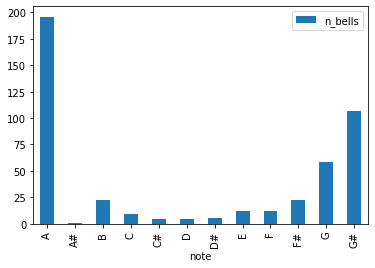

In [8]:
note_stats(de[DE['note_col']])

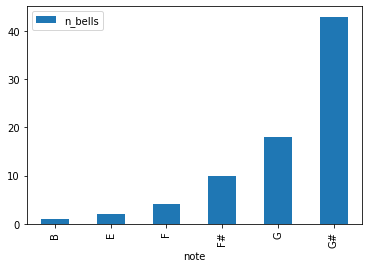

In [9]:
note_stats(ch[CH['note_col']])

missed: ['Do', '(?)']


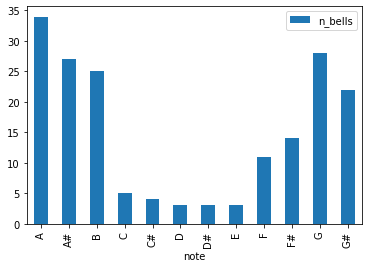

In [10]:
note_stats(fr[FR['note_col']], french=True)

In [11]:
def get_frequency(midi_note_optional_delta: str, *, pitch_reference: int = 440) -> float:
    midi_note, delta = MIDI_NOTE_OPTIONAL_DELTA.fullmatch(midi_note_optional_delta).groups()
    midi_number = MIDI_NOTES.index(midi_note)
    if delta:
        midi_number += int(delta) / 16
        
    frequency = 2 ** ((midi_number - 69) / 12) * pitch_reference
    return round(frequency, 3)


assert get_frequency('A4') == 440
assert get_frequency('G#3') == 207.652

assert get_frequency('G#3-8/16') == 201.741

assert round(get_frequency('E4+6/16', pitch_reference=435), 1) == 333


def frequency_stats(bell_notes, *, plot='bar', french=False, include_deltas=False, pitch_reference=440):
    df = (bell_notes.value_counts().to_frame('n_bells')
          .assign(midi_note=lambda x: x.index.to_series().pipe(to_notes, french=french, as_midi=True,
                                                               include_delta=include_deltas))
          .dropna()
          .assign(frequency=lambda x: x['midi_note'].apply(get_frequency, pitch_reference=pitch_reference)))

    operator.methodcaller(plot)(df.groupby('frequency')['n_bells'].sum().to_frame('n_bells').plot)

    return (df.groupby(['midi_note', 'frequency'])['n_bells'].sum().to_frame('n_bells')
            .reset_index('frequency').sort_values(by='frequency', ascending=False))

missed: ['h0/c1', "a'0"]


,frequency,n_bells
midi_note,,
C5,523.251,1
A4,440.000,1
G4,391.995,1
F4,349.228,1
E4,329.628,1
D#4,311.127,3
D4,293.665,3
C#4,277.183,3
C4,261.626,7


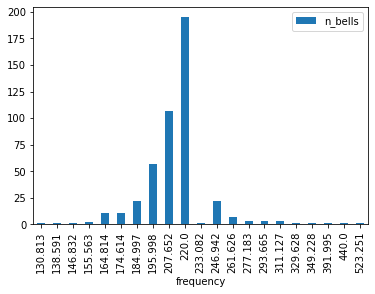

In [12]:
frequency_stats(de[DE['note_col']])

missed: ['h0/c1', "a'0"]


,frequency,n_bells
midi_note,,
C5-6/16,512.039,1
A4,440.000,1
G4,391.995,1
F4+7/16,358.166,1
E4+3/16,333.217,1
D#4+5/16,316.794,1
D#4,311.127,1
D#4-2/16,308.889,1
D4,293.665,2


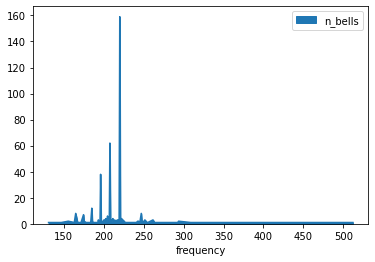

In [13]:
frequency_stats(de[DE['note_col']], include_deltas=True, plot='area').head(60)

,frequency,n_bells
midi_note,,
B3,246.942,1
G#3,207.652,43
G3,195.998,18
F#3,184.997,10
F3,174.614,4
E3,164.814,2


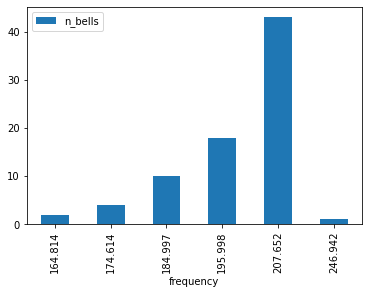

In [14]:
frequency_stats(ch[CH['note_col']])

,frequency,n_bells
midi_note,,
B3,246.942,1
G#3,207.652,43
G3,195.998,17
G3-5/16,192.492,1
F#3,184.997,10
F3,174.614,4
E3+3/16,166.608,1
E3,164.814,1


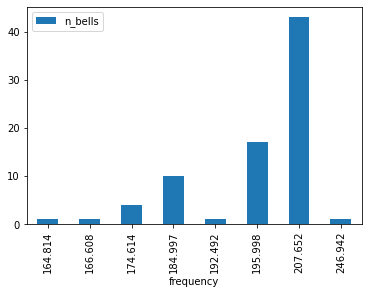

In [15]:
frequency_stats(ch[CH['note_col']], include_deltas=True).head(40)

missed: ['Do', '(?)']


,frequency,n_bells
midi_note,,
C#4,277.183,2
C4,261.626,4
B3,246.942,25
A#3,233.082,27
A3,220.000,34
G#3,207.652,22
G3,195.998,28
F#3,184.997,14
F3,174.614,11


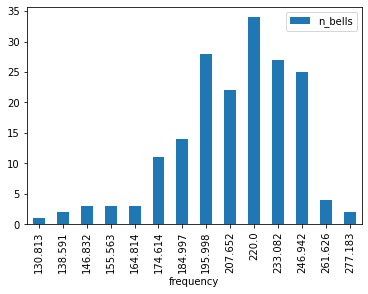

In [16]:
frequency_stats(fr[FR['note_col']], french=True)

missed: ['Do', '(?)']


,frequency,n_bells
midi_note,,
C#4,277.183,2
C4,261.626,4
B3,246.942,25
A#3,233.082,26
A#3-5/16,228.912,1
A3+7/16,225.630,1
A3,220.000,33
G#3,207.652,22
G3+5/16,199.568,1


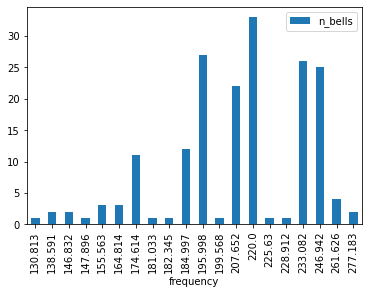

In [17]:
frequency_stats(fr[FR['note_col']], french=True, include_deltas=True)